In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import copy
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()
finaltest = copy.copy(test_data)
import cv2
import matplotlib.pyplot as plt


In [2]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
# Print list of available GPUs
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Verify GPU support
print("GPU Support:", tf.test.is_built_with_cuda())
print("GPU Device Name:", tf.test.gpu_device_name())

Num GPUs Available: 1
GPU Support: True
GPU Device Name: /device:GPU:0


In [4]:
def preprocess(X,Y):
    x_p = K.applications.resnet50.preprocess_input(X)
    y_p = K.utils.to_categorical(Y,10)
    return x_p,y_p

# print(train_data)
train_data,train_labels = preprocess(train_data,train_labels)
print()
# print(train_data)
test_data,test_labels =  preprocess(test_data,test_labels)

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [8]:
input_t = K.Input(shape=(32,32,3))
# Load ResNet50 model
base_model = ResNet50(include_top=False, weights=None, input_tensor=input_t)

# Load weights from file
weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_file)

# Create a new model with the loaded weights
res_model = Model(inputs=base_model.input, outputs=base_model.output)


In [9]:
for layer in res_model.layers[:143]:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)

model.add(K.layers.Flatten())
model.add(K.layers.Dense(10, activation='softmax'))

In [10]:
# train_labels

In [11]:
# train_data

In [11]:
# check_point = K.callbacks.ModelCheckpoint(filepath="cifar10.h5",monitor="val-acc",mode="max",save_best_only=True)
def categorical_crossentropy(y_true, y_pred):
    print(y_pred)
    # Avoid numerical instability due to log(0)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    # Compute cross-entropy loss
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return loss

model.compile(loss=categorical_crossentropy,optimizer=K.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy'])
# history = model.fit(train_datanew,train_labelsnew,batch_size=128,epochs=1,verbose=1,validation_data=(test_datanew,test_labelsnew),
#                    callbacks=[check_point])
history = model.fit(train_data,train_labels,batch_size=32,epochs=1,verbose=1)
model.summary()

Tensor("sequential/dense/Softmax:0", shape=(None, 10), dtype=float32)
Tensor("sequential/dense/Softmax:0", shape=(None, 10), dtype=float32)
1563/1563 [==============================] - 91s 54ms/step - loss: 1.6945 - accuracy: 0.4764
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 14,996,490
Non-trainable params: 8,611,712
_________________________________________________________________


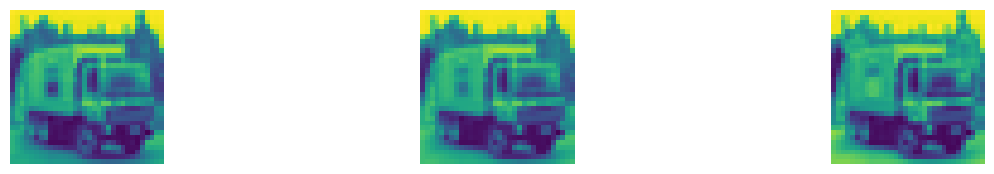

preditcion :  9
real :  9


In [12]:
# draw activations of a layer in res_model
import matplotlib.pyplot as plt
import numpy as np

instanceNumber = 11
# Select the layer for which you want to visualize activations
layer_to_visualize = res_model.layers[0]

# Create a model that outputs the activations of the desired layer
activation_model = K.models.Model(inputs=res_model.input, outputs=layer_to_visualize.output)

# # Get a sample image and preprocess it
# sample_image = ...  # Load or create your sample image here
# sample_image = preprocess_image(sample_image)  # Implement this function to resize and normalize the image
sample_image = test_data[instanceNumber]



# Expand the dimensions of the image to match the model's input shape (batch size of 1)
sample_image = np.expand_dims(sample_image, axis=0)

# Get the activations for the sample image
activations = activation_model.predict(sample_image)

# Visualize the activations (assuming a 4D tensor with shape (1, h, w, c))
num_activations = activations.shape[-1]
fig, axs = plt.subplots(1, num_activations, figsize=(15, 2))

for i in range(num_activations):
    axs[i].imshow(activations[0, :, :, i], cmap='viridis')  # Use any colormap you prefer
    axs[i].axis('off')



plt.show()
sample_image = test_data[instanceNumber]
input_image = np.expand_dims(sample_image, axis=0)
prediction = model.predict(input_image)
print("preditcion : ",np.argmax(prediction))
print("real : ",np.argmax(test_labels[instanceNumber]))

In [13]:
predictions = model.predict(test_data)

sample_image = test_data[1]
# Expand the dimensions to match the model's input shape (batch size of 1)
input_image = np.expand_dims(sample_image, axis=0)

# Make the prediction
prediction = model.predict(input_image)

# The 'prediction' is an array of probabilities for each class
# To get the predicted class label, find the index of the highest probability
predicted_class_index = np.argmax(prediction)
predicted_class_index


1

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

newypred = []
newlabel = []
for i in range(len(predictions)):
#     plt.imshow(finaltest[i])
#     plt.show()
    newypred.append(predictions[i].argmax())
    newlabel.append(test_labels[i].argmax())
#     print(predictions[i].argmax(),test_labels[i].argmax())
    
    
conf_matrix = confusion_matrix(newlabel, newypred)
accuracy_score = accuracy_score(newlabel, newypred)
print("confusion matrix : \n",conf_matrix,"\n\n accuracy : ",accuracy_score)

confusion matrix : 
 [[657  30  63  21  18   8  17  27 110  49]
 [ 47 681   6  24  11  11   9  26  50 135]
 [ 75  25 473  85 109  52 108  49  17   7]
 [ 30  45  77 448  48 150  94  60  20  28]
 [ 22  11  85  63 522  39 109 111  24  14]
 [  8  21  68 186  45 527  58  72   5  10]
 [ 12  17  66  66  81  39 692  15   7   5]
 [ 26  18  43  63  86  54  20 638  15  37]
 [127  74  16  17  14   5   6  12 662  67]
 [ 48 161  14  18   8  11   9  37  54 640]] 

 accuracy :  0.594


In [15]:
predictions = model.predict(train_data)
newypred = []
newlabel = []
for i in range(len(predictions)):
#     plt.imshow(finaltest[i])
#     plt.show()
    newypred.append(predictions[i].argmax())
    newlabel.append(train_labels[i].argmax())
#     print(predictions[i].argmax(),test_labels[i].argmax())
    


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
conf_matrix = confusion_matrix(newlabel, newypred)
accuracy_score = accuracy_score(newlabel, newypred)
print("confusion matrix : \n",conf_matrix,"\n\n accuracy : ",accuracy_score)

confusion matrix : 
 [[3576  175  206  107   83   59   59  109  437  189]
 [ 165 3727   44  121   42   55   56   62  197  531]
 [ 262   89 2844  308  483  248  409  221   95   41]
 [  99  128  266 2748  226  660  415  231   96  131]
 [ 132   62  339  272 2940  168  368  546  100   73]
 [  53   92  256  767  217 2952  241  332   35   55]
 [  53   53  225  301  306  165 3778   77   26   16]
 [  99  102  175  245  381  218   90 3486   53  151]
 [ 491  262   56   68   47   25   25   28 3766  232]
 [ 184  660   26  101   57   55   30   98  212 3577]] 

 accuracy :  0.66788
